<a href="https://www.kaggle.com/code/abrahamtavarez/genai-langchain-demo?scriptVersionId=232175023" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# Install langgraph and the packages used in this lab.
!pip install -qU 'langgraph==0.3.21' 'langchain-google-genai==2.1.2' 'langgraph-prebuilt==0.1.7' 'langchain-core==0.3.51'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.3/423.3 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 9.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.3 requires google-ai-generativelanguage==0.6.10, but you have google-ai-generativelanguage 0.6.17 which is incompatible.
langchain 0.3.12 requires async-timeout<5.0.0,>=

In [2]:
import os
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

In [3]:
from typing import Annotated
from typing_extensions import TypedDict, List

from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import SystemMessage, HumanMessage

# App state for the graph (this state flows through the graph from node to node)
class State(TypedDict):
    video_url: str
    comments: str
    #comments: List[str] # <--- test
    messages: Annotated[list, add_messages]


# Youtube comments (dummy) / will be fetched from API later
comments = [
    "how does every person wired brings on this show act like they've been in front of cameras 5000 times"
]


# Returns comments (dummy) / will be fetched from API later
def get_comments(state: State):
    print("GET_COMMENTS_STATE::: ", state)
    print(f"fetching comments from url: {state['video_url']}")
    return {"comments": comments[0]} # <--- returns just the first message 


# Model
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")


# Sytem Prompt/message
system_prompt = "You are a helpful content creator assitant. Your job is create new fun and engaging video ideas from the following user comments: {comments}."

prompt_template = ChatPromptTemplate.from_messages(
    [
        ("user",system_prompt)
    ]
)

def chatbot(state: State):
    print("CHATBOT_STATE::: ", state)
    messages_template = prompt_template.invoke({"comments": comments[0]}) # <--- format comments
    print("MESSAGES HISTORY TEMPLATE::: ", messages_template)

    messages = messages_template.to_messages()
    print("MESSAGES::: ", messages)
    completion = llm.invoke(messages)
    print("COMPLETION:: ", completion)
    return {"messages": messages}


# Create a new Graph using langchain using the State definition
# Sidenote:  You can think of a directed graph as a sequence of instructions composed of nodes and edges, that tell you how to complete a task.
graph_builder = StateGraph(State)

# Add nodes/functionality or action to the graph
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("get_comments", get_comments)

# Set the entry point of the app
graph_builder.add_edge(START, "get_comments")
graph_builder.add_edge("get_comments", "chatbot")

chat_graph = graph_builder.compile()

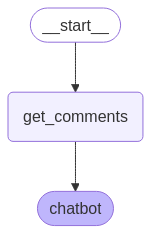

In [4]:
from IPython.display import Image, display

Image(chat_graph.get_graph().draw_mermaid_png())

In [5]:
from pprint import pprint

result = chat_graph.invoke({"video_url": "https://youtube.com/@me/vid-123"})

pprint(result)

GET_COMMENTS_STATE:::  {'video_url': 'https://youtube.com/@me/vid-123', 'messages': []}
fetching comments from url: https://youtube.com/@me/vid-123
CHATBOT_STATE:::  {'video_url': 'https://youtube.com/@me/vid-123', 'comments': "how does every person wired brings on this show act like they've been in front of cameras 5000 times", 'messages': []}
MESSAGES HISTORY TEMPLATE:::  messages=[HumanMessage(content="You are a helpful content creator assitant. Your job is create new fun and engaging video ideas from the following user comments: how does every person wired brings on this show act like they've been in front of cameras 5000 times.", additional_kwargs={}, response_metadata={})]
MESSAGES:::  [HumanMessage(content="You are a helpful content creator assitant. Your job is create new fun and engaging video ideas from the following user comments: how does every person wired brings on this show act like they've been in front of cameras 5000 times.", additional_kwargs={}, response_metadata={}

**Sample Response:**

{'comments': "how does every person wired brings on this show act like they've "
             'been in front of cameras 5000 times',
 'messages': [AIMessage(content='Okay, I can work with that! This comment highlights a potential disconnect between the perceived "average person" Wired brings on and their polished on-camera presence. Here are a few video ideas playing off that observation:\n\n**Video Idea 1: "Wired Debunked: Are Our Guests Secretly Professional Speakers?"**\n\n*   **Concept:** A humorous investigation into whether Wired\'s guests are actually just really good at faking it.\n*   **Content:**\n    *   Start with a montage of Wired guests looking incredibly comfortable and articulate.\n    *   Introduce the commenter\'s question.\n    *   Interview past Wired guests:\n        *   Ask them directly about their on-camera experience *before* appearing on Wired.\n        *   Probe for tips and tricks they used to appear so confident.\n        *   (Humorously) Accuse them of being secret actors.\n    *   Consult a public speaking coach:\n        *   Ask them to analyze Wired guest appearances and point out techniques used.\n        *   Get their tips for appearing more confident on camera.\n    *   Test the "Wired Effect": Put a completely random person in front of a camera and see how they do, then give them some basic tips and try again.\n    *   End with a lighthearted conclusion: Maybe everyone *can* be a great on-camera presence with a little preparation (or maybe some of them *are* secretly plants!).\n*   **Tone:** Humorous, slightly skeptical, but ultimately positive and encouraging.\n*   **Target Audience:** Wired viewers, people interested in public speaking, anyone curious about media production.\n\n**Video Idea 2: "The Wired Confidence Hack: How to Look Like a Pro on Camera (Even if You\'re Not)"**\n\n*   **Concept:** A practical guide to improving your on-camera presence, inspired by the seemingly effortless confidence of Wired guests.\n*   **Content:**\n    *   Acknowledge the commenter\'s observation and frame it as a common aspiration.\n    *   Break down the key elements of a good on-camera presence:\n        *   Eye contact and connection with the interviewer.\n        *   Clear and concise communication.\n        *   Body language and posture.\n        *   Enthusiasm and passion for the topic.\n    *   Provide actionable tips and exercises for each element:\n        *   Eye contact drills.\n        *   Practicing concise answers.\n        *   Power posing techniques.\n        *   Finding your passion for the topic.\n    *   Include examples from Wired videos, highlighting specific guests who demonstrate these techniques effectively.\n    *   Offer a "before and after" example: Show someone trying to explain a concept on camera before and after applying the tips.\n*   **Tone:** Informative, practical, and encouraging.\n*   **Target Audience:** Anyone who wants to improve their on-camera presence, content creators, students, professionals.\n\n**Video Idea 3: "Behind the Scenes at Wired: What *Really* Happens Before the Camera Rolls?"**\n\n*   **Concept:** A peek behind the curtain at the Wired interview process, showing what goes into making guests look so polished.\n*   **Content:**\n    *   Interview Wired producers and editors:\n        *   Ask about their pre-interview preparation process.\n        *   Do they provide guests with talking points or coaching?\n        *   What kind of environment do they create to make guests feel comfortable?\n    *   Show footage of pre-interview conversations and setup.\n    *   Highlight any behind-the-scenes techniques used to help guests relax and deliver their best performance (e.g., friendly banter, clear instructions, comfortable lighting).\n    *   Address the commenter\'s question directly: "Is there a secret formula to making Wired guests look so good on camera?"\n    *   Maybe even show some *failed* takes or moments where guests struggled, to humanize the process.\n*   **Tone:** Informative, engaging, and slightly revealing.\n*   **Target Audience:** Wired viewers, media production enthusiasts, anyone curious about the behind-the-scenes of video creation.\n\n**Why These Ideas Work:**\n\n*   **Addresses the Comment Directly:** Each idea acknowledges and explores the question raised in the comment.\n*   **Offers Different Angles:** The ideas approach the topic from humorous, practical, and behind-the-scenes perspectives.\n*   **Leverages Wired\'s Brand:** The ideas use Wired\'s existing content and reputation to create engaging and relevant videos.\n*   **Potential for High Engagement:** The topic is relatable and intriguing, with the potential to spark discussion and generate views.\n\nI think these video ideas would be fun to create and watch! Good luck!', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run-32a3ac80-f31e-4992-b3bd-d9e1af0ad979-0', usage_metadata={'input_tokens': 53, 'output_tokens': 998, 'total_tokens': 1051, 'input_token_details': {'cache_read': 0}})],
 'video_url': 'https://youtube.com/@me/vid-123'}